In [60]:
# Лабораторная работа №4

# Тема: Исследовательский анализ данных (EDA) и построение Baseline-модели
# Проект: Сервис определения языка текста
# Выполнили: Дягилева М. С., Куликов А. Ю.

In [61]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [62]:
df = pd.read_csv('sentences.csv')
print("Размер датасета:", df.shape)
print("\nПервые 5 строк:")
df.head()

Размер датасета: (10341812, 3)

Первые 5 строк:


,id,lan_code,sentence
0,1,cmn,我們試試看！
1,2,cmn,我该去睡觉了。
2,3,cmn,你在干什麼啊？
3,4,cmn,這是什麼啊？
4,5,cmn,今天是６月１８号，也是Muiriel的生日！


In [63]:
df = df.sample(2000, random_state=42)  # Возьмите только 2000 случайных строк
print(f"Используем подвыборку: {len(df)} строк")

Используем подвыборку: 2000 строк


In [64]:
print("Информация о датасете:")
df.info()
print("\nПроверка пропусков:")
print(df.isnull().sum())

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 6680055 to 9058717
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        2000 non-null   int64 
 1   lan_code  2000 non-null   object
 2   sentence  2000 non-null   object
dtypes: int64(1), object(2)
memory usage: 62.5+ KB

Проверка пропусков:
id          0
lan_code    0
sentence    0
dtype: int64


In [65]:
print("Количество дубликатов:", df.duplicated().sum())
df = df.drop_duplicates()
print("Размер после удаления дубликатов:", df.shape)

Количество дубликатов: 0
Размер после удаления дубликатов: (2000, 3)


In [66]:
# Статистика по языкам
print("Распределение по языкам:")
lang_dist = df['lan_code'].value_counts()
print(lang_dist)
print(f"\nВсего языков: {len(lang_dist)}")

Распределение по языкам:
lan_code
eng    307
rus    189
tur    146
ita    144
epo    125
      ... 
khm      1
lvs      1
bua      1
grc      1
glg      1
Name: count, Length: 91, dtype: int64

Всего языков: 91


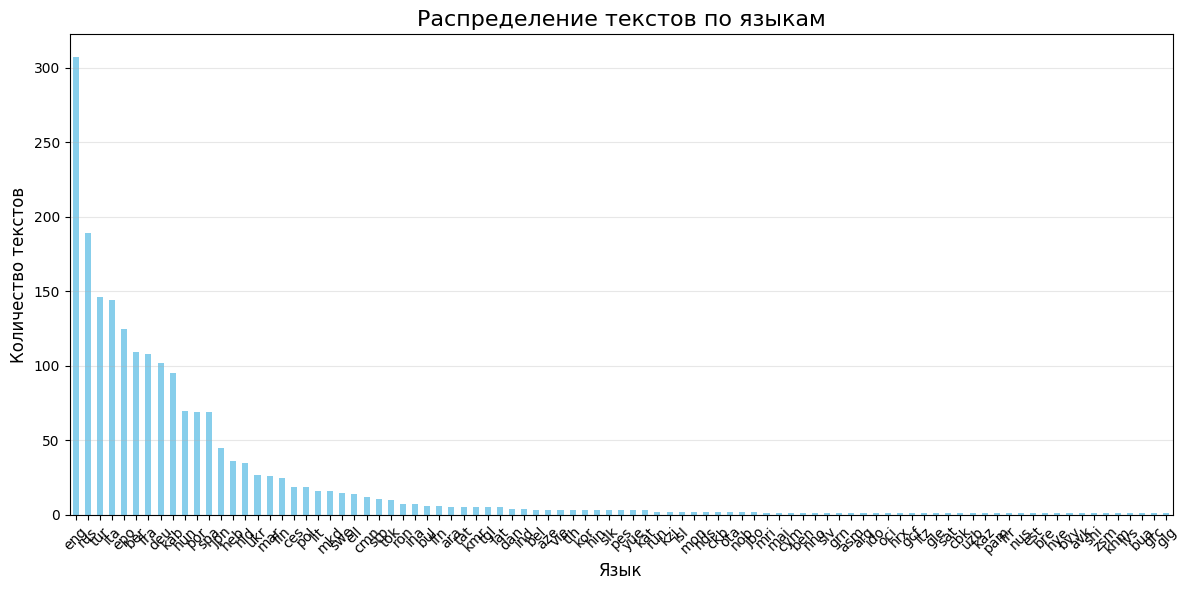

In [67]:
# Визуализация 1: Распределение языков (категориальный признак)
plt.figure(figsize=(12, 6))
lang_dist.plot(kind='bar', color='skyblue')
plt.title('Распределение текстов по языкам', fontsize=16)
plt.xlabel('Язык', fontsize=12)
plt.ylabel('Количество текстов', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

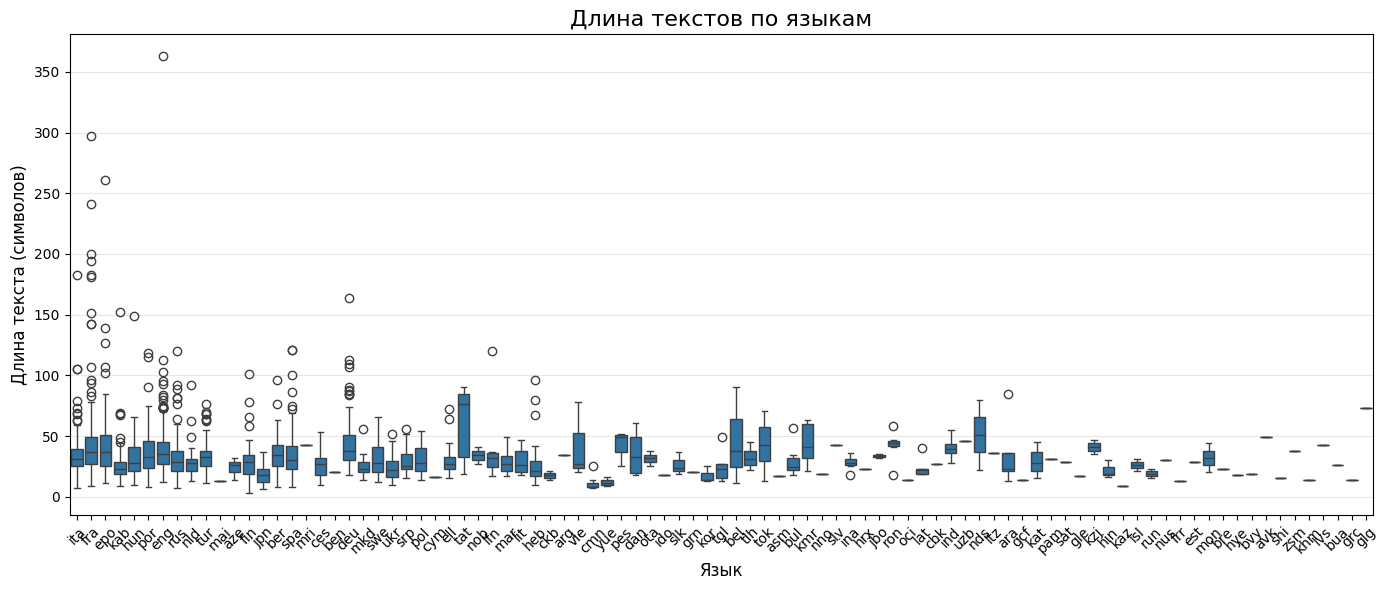

In [68]:
# Визуализация 2: Длина текстов по языкам (числовой признак)
df['text_length'] = df['sentence'].apply(len)

plt.figure(figsize=(14, 6))
sns.boxplot(x='lan_code', y='text_length', data=df)
plt.title('Длина текстов по языкам', fontsize=16)
plt.xlabel('Язык', fontsize=12)
plt.ylabel('Длина текста (символов)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Всего слов в английских текстах: 2328
Уникальных слов: 806

Топ-20 самых частых слов:
to: 86
tom: 75
the: 75
i: 72
that: 60
a: 51
you: 39
and: 34
in: 34
is: 28
mary: 28
of: 27
he: 26
do: 25
was: 25
she: 20
dont: 19
are: 18
my: 18
it: 17


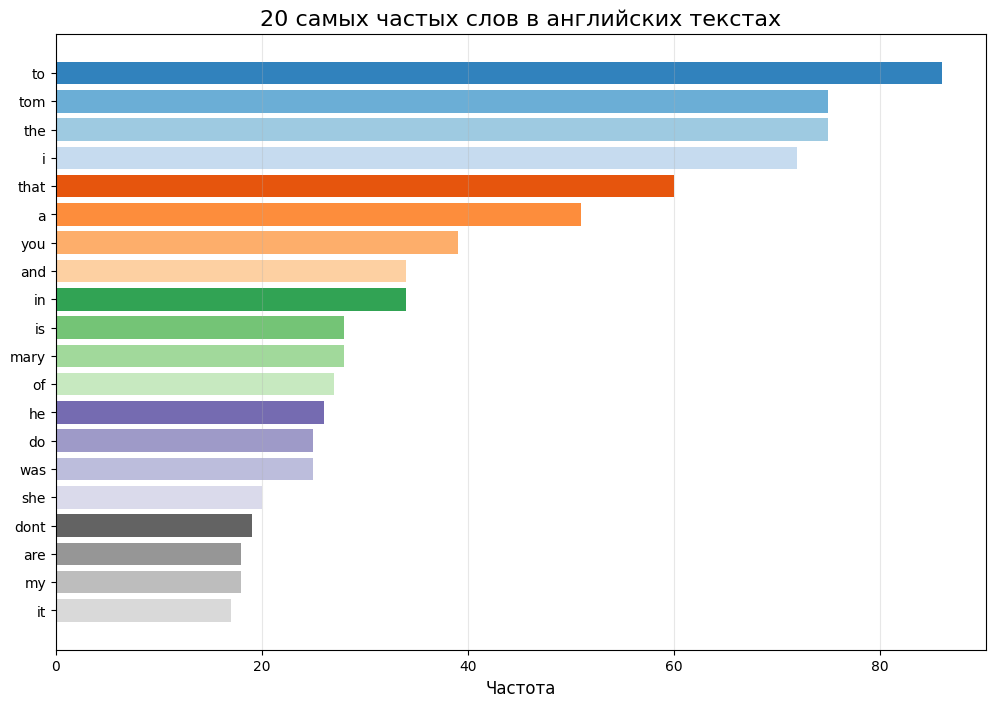

In [69]:
def clean_text(text):
    """Очистка текста: удаление пунктуации и приведение к нижнему регистру"""
    # Проверяем, что текст является строкой
    if isinstance(text, str):
        text = re.sub(r'[^\w\s]', '', text.lower())
        return text
    else:
        # Если это не строка, возвращаем пустую строку
        return ""


# Получаем английские тексты
english_texts = ' '.join(df[df['lan_code'] == 'eng']['sentence'].apply(clean_text))

# 3. Анализ частоты слов
words = english_texts.split()
print(f"Всего слов в английских текстах: {len(words)}")
print(f"Уникальных слов: {len(set(words))}")

# Получаем 20 самых частых слов
word_freq = Counter(words).most_common(20)
print("\nТоп-20 самых частых слов:")
for word, freq in word_freq:
    print(f"{word}: {freq}")

# 4. Визуализация
plt.figure(figsize=(12, 8))
words_list, frequencies = zip(*word_freq)
colors = plt.cm.tab20c(range(len(words_list)))

bars = plt.barh(words_list[::-1], frequencies[::-1], color=colors[::-1])
plt.xlabel('Частота', fontsize=12)
plt.title('20 самых частых слов в английских текстах', fontsize=16)
plt.grid(axis='x', alpha=0.3)

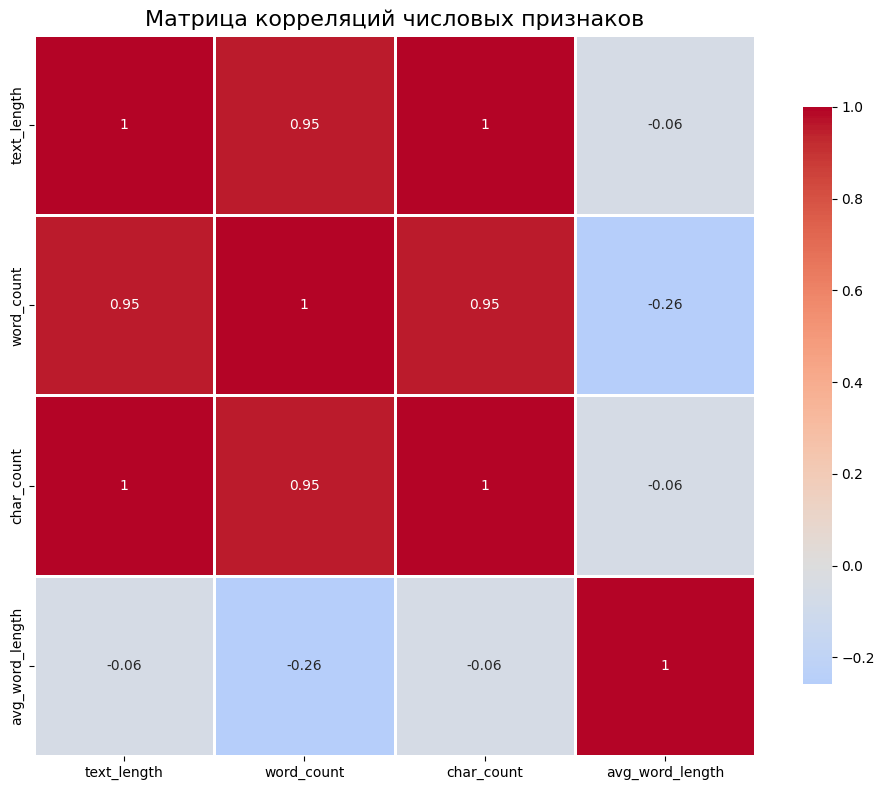

In [70]:
# Визуализация 4: Матрица корреляций для числовых признаков
# Создаем дополнительные признаки
df['word_count'] = df['sentence'].apply(lambda x: len(str(x).split()))
df['char_count'] = df['sentence'].apply(len)
df['avg_word_length'] = df['char_count'] / df['word_count']

numeric_features = df[['text_length', 'word_count', 'char_count', 'avg_word_length']]

plt.figure(figsize=(10, 8))
sns.heatmap(numeric_features.corr(), annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Матрица корреляций числовых признаков', fontsize=16)
plt.tight_layout()
plt.show()

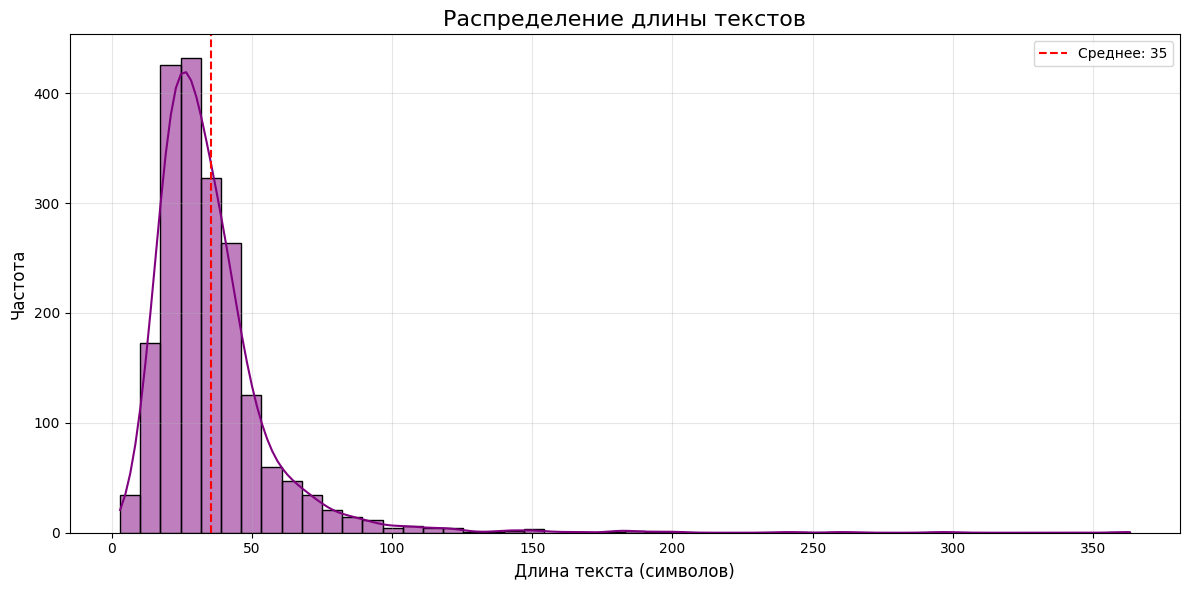

In [71]:
# Визуализация 5: Распределение длины текстов (гистограмма)
plt.figure(figsize=(12, 6))
sns.histplot(df['text_length'], bins=50, kde=True, color='purple')
plt.title('Распределение длины текстов', fontsize=16)
plt.xlabel('Длина текста (символов)', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.grid(alpha=0.3)
plt.axvline(df['text_length'].mean(), color='red', linestyle='--', 
            label=f'Среднее: {df["text_length"].mean():.0f}')
plt.legend()
plt.tight_layout()
plt.show()

In [72]:
# Создание новых признаков на основе инсайтов из EDA
def extract_features(text):
    features = {}
    
    # Базовые признаки
    features['length'] = len(text)
    features['word_count'] = len(text.split())
    
    # Признаки на основе символов
    features['digit_ratio'] = sum(c.isdigit() for c in text) / max(len(text), 1)
    features['upper_ratio'] = sum(c.isupper() for c in text) / max(len(text), 1)
    features['space_ratio'] = sum(c.isspace() for c in text) / max(len(text), 1)
    
    # Языко-специфичные признаки (пример для латиницы и кириллицы)
    features['latin_chars'] = sum(c.isalpha() and ord(c) < 128 for c in text)
    features['non_latin_chars'] = sum(c.isalpha() and ord(c) >= 128 for c in text)
    
    return features

In [73]:
print("Проверка данных перед обработкой:")
print("=" * 50)

# Проверим типы данных
print(f"Тип столбца 'sentence': {df['sentence'].dtype}")
print(f"Количество строк: {len(df)}")

# Проверим наличие NaN значений
nan_count = df['sentence'].isna().sum()
print(f"NaN значений в 'sentence': {nan_count}")

# Проверим некорректные типы данных
non_string_count = 0
non_string_examples = []
for i, val in enumerate(df['sentence']):
    if not isinstance(val, str):
        non_string_count += 1
        if len(non_string_examples) < 5:
            non_string_examples.append((i, val, type(val)))

print(f"Некорректных (не строковых) значений: {non_string_count}")
if non_string_examples:
    print("Примеры некорректных значений:")
    for idx, val, typ in non_string_examples:
        print(f"  Строка {idx}: значение={val}, тип={typ}")

# Посмотрим первые несколько некорректных значений
if non_string_count > 0:
    print("\nПервые 5 некорректных значений:")
    non_string_values = df['sentence'][~df['sentence'].apply(lambda x: isinstance(x, str))]
    print(non_string_values.head())

# Проверим также столбец с языками
print(f"\nУникальные значения в 'lan_code': {df['lan_code'].unique()[:20]}")

Проверка данных перед обработкой:
Тип столбца 'sentence': object
Количество строк: 2000
NaN значений в 'sentence': 0
Некорректных (не строковых) значений: 0

Уникальные значения в 'lan_code': ['ita' 'fra' 'epo' 'kab' 'hun' 'por' 'eng' 'rus' 'nld' 'tur' 'mai' 'aze'
 'fin' 'jpn' 'ber' 'spa' 'mri' 'ces' 'ben' 'deu']


In [74]:
# Сохраним исходное количество строк
original_count = len(df)

# Вариант 1: Удалить строки с некорректными данными
df_clean = df.copy()
df_clean = df_clean[df_clean['sentence'].apply(lambda x: isinstance(x, str))]

print(f"\nОчистка данных:")
print(f"Исходное количество строк: {original_count}")
print(f"Количество строк после очистки: {len(df_clean)}")
print(f"Удалено строк: {original_count - len(df_clean)}")

# Проверяем, что все значения теперь строки
all_strings = all(isinstance(x, str) for x in df_clean['sentence'])
print(f"Все значения теперь строки: {all_strings}")


Очистка данных:
Исходное количество строк: 2000
Количество строк после очистки: 2000
Удалено строк: 0
Все значения теперь строки: True


In [75]:
# Применяем функцию к данным
# Используем очищенные данные
features_list = []
processed_count = 0

print("\nИзвлечение признаков...")
for i, text in enumerate(df_clean['sentence']):
    try:
        features_list.append(extract_features(text))
        processed_count += 1
        if processed_count % 1000 == 0:
            print(f"Обработано {processed_count} текстов...")
    except Exception as e:
        print(f"Ошибка при обработке строки {i}: {e}")
        print(f"Текст: {text[:100]}...")
        features_list.append(extract_features(""))  # добавляем пустые признаки

print(f"Всего обработано: {processed_count} текстов")

# Создаем DataFrame с признаками
features_df = pd.DataFrame(features_list)

# Добавляем признаки к исходным данным
df_with_features = pd.concat([df_clean.reset_index(drop=True), features_df], axis=1)

print(f"\nНовые признаки добавлены:")
print(f"Исходные столбцы: {df_clean.columns.tolist()}")
print(f"Добавленные признаки: {features_df.columns.tolist()}")
print(f"Всего столбцов: {df_with_features.shape[1]}")
print(f"Всего строк: {df_with_features.shape[0]}")

# Просмотр результата
print("\nПервые 5 строк с новыми признаками:")
print(df_with_features[['sentence', 'length', 'word_count', 'avg_word_length']].head())


Извлечение признаков...
Обработано 1000 текстов...
Обработано 2000 текстов...
Всего обработано: 2000 текстов

Новые признаки добавлены:
Исходные столбцы: ['id', 'lan_code', 'sentence', 'text_length', 'word_count', 'char_count', 'avg_word_length']
Добавленные признаки: ['length', 'word_count', 'digit_ratio', 'upper_ratio', 'space_ratio', 'latin_chars', 'non_latin_chars']
Всего столбцов: 14
Всего строк: 2000

Первые 5 строк с новыми признаками:
                                          sentence  length  word_count  \
0            Il tuo futuro è pieno di possibilità.      37           7   
1             J'aimerais aller en France, un jour.      36           6   
2  La polica enketo aperigis ilian sekretan vivon.      47           7   
3                              Kullec ifukk yid-k.      19           3   
4                Több munkát nem tudok elvállalni.      33           5   

   word_count  avg_word_length  
0           7         5.285714  
1           6         6.000000  
2       

In [76]:
# Подготовка данных для модели
X = df[['length', 'word_count', 'digit_ratio', 'upper_ratio', 
        'space_ratio', 'latin_chars', 'non_latin_chars']]
y = df['id']

print(f"Размер матрицы признаков: {X.shape}")
print(f"Размер целевой переменной: {y.shape}")

KeyError: "['length', 'digit_ratio', 'upper_ratio', 'space_ratio', 'latin_chars', 'non_latin_chars'] not in index"

In [ ]:
print("Анализ данных перед разделением:")
print("=" * 50)

# Проверяем наличие NaN в X и y
print(f"Всего строк в данных: {len(X)}")
print(f"NaN в X: {X.isna().sum().sum()}")
print(f"NaN в y: {y.isna().sum()}")

# Покажем строки с NaN в y
nan_indices = y[y.isna()].index
if len(nan_indices) > 0:
    print(f"\nИндексы строк с NaN в y: {nan_indices.tolist()[:10]}")  # первые 10
    
    # Посмотрим на эти строки
    print("\nПримеры строк с NaN в language_encoded:")
    nan_rows = df.loc[nan_indices]
    print(nan_rows[['sentence', 'lan_code']].head())
    
    # Проверим, почему language_encoded NaN
    print("\nПроверка исходных данных:")
    for idx in nan_indices[:5]:  # первые 5 строк для примера
        print(f"\nСтрока {idx}:")
        print(f"  lan_code: {df.loc[idx, 'lan_code']}")
        print(f"  id: {df.loc[idx, 'id']}")
        print(f"  Тип lan_code: {type(df.loc[idx, 'lan_code'])}")

Анализ данных перед разделением:
Всего строк в данных: 4000
NaN в X: 16000
NaN в y: 2000

Индексы строк с NaN в y: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Примеры строк с NaN в language_encoded:
  sentence lan_code
0      NaN      NaN
1      NaN      NaN
2      NaN      NaN
3      NaN      NaN
4      NaN      NaN

Проверка исходных данных:

Строка 0:
  lan_code: nan
  id: nan
  Тип lan_code: <class 'float'>

Строка 1:
  lan_code: nan
  id: nan
  Тип lan_code: <class 'float'>

Строка 2:
  lan_code: nan
  id: nan
  Тип lan_code: <class 'float'>

Строка 3:
  lan_code: nan
  id: nan
  Тип lan_code: <class 'float'>

Строка 4:
  lan_code: nan
  id: nan
  Тип lan_code: <class 'float'>


In [ ]:
# Вариант 2: Заполнить NaN (если можем определить язык)
def fix_language_encoding(df):
    """Исправление проблем с кодированием языков"""
    df_fixed = df.copy()
    
    # Проверяем, есть ли NaN в language_encoded
    nan_mask = df_fixed['id'].isna()
    
    if nan_mask.any():
        print(f"Найдено {nan_mask.sum()} строк с NaN в language_encoded")
        
        # Попробуем определить язык из lan_code
        for idx in df_fixed[nan_mask].index:
            lang_code = df_fixed.loc[idx, 'lan_code']
            
            if pd.isna(lang_code):
                # Если lan_code тоже NaN, удаляем строку
                df_fixed.loc[idx, 'id'] = np.nan
            else:
                # Пытаемся закодировать
                try:
                    # Если label_encoder уже обучен
                    encoded = label_encoder.transform([lang_code])[0]
                    df_fixed.loc[idx, 'id'] = encoded
                except:
                    # Если язык новый, добавляем его
                    print(f"Новый язык '{lang_code}' в строке {idx}")
                    # Для простоты удаляем такие строки
                    df_fixed.loc[idx, 'language_encoded'] = np.nan
    
    # Удаляем строки, которые не удалось исправить
    df_fixed = df_fixed.dropna(subset=['id'])
    return df_fixed

# Применяем функцию
print("\nИсправление данных...")
df = fix_language_encoding(df)


Исправление данных...
Найдено 2000 строк с NaN в language_encoded


In [ ]:
# Проверяем, что столбец 'language_encoded' существует и не содержит NaN
if 'id' not in df.columns:
    print("Столбец 'language_encoded' не найден, создаем заново...")
    
    # Находим столбец с языками
    lang_column = 'lan_code' if 'lan_code' in df.columns else None
    if lang_column:
        # Перекодируем языки
        label_encoder = LabelEncoder()
        df['id'] = label_encoder.fit_transform(df[lang_column])
        
        print("Языки закодированы заново")
        print(f"Классы: {label_encoder.classes_}")
    else:
        print("Ошибка: не найден столбец с языками!")

# Еще раз проверяем NaN
print(f"\nФинальная проверка:")
print(f"NaN в language_encoded: {df['id'].isna().sum()}")

# Удаляем оставшиеся NaN (если есть)
if df['id'].isna().sum() > 0:
    print("Удаляем строки с NaN...")
    df = df.dropna(subset=['id'])

# Проверяем признаки
print(f"\nДоступные признаки:")
print(X.columns.tolist() if 'X' in locals() else "X не определен")

# Создаем X и y заново
required_features = ['length', 'word_count', 'digit_ratio', 'upper_ratio']
available_features = [feat for feat in required_features if feat in df.columns]

if not available_features:
    print("ОШИБКА: Нет доступных признаков!")
    print(f"Доступные столбцы: {df.columns.tolist()}")
    
    # Создаем базовые признаки если их нет
    print("\nСоздаем базовые признаки...")
    if 'sentence' in df.columns:
        df['length'] = df['sentence'].apply(lambda x: len(str(x)))
        df['word_count'] = df['sentence'].apply(lambda x: len(str(x).split()))
        available_features = ['length', 'word_count']
    else:
        print("Нет столбца с текстом для создания признаков!")
else:
    print(f"Используем признаки: {available_features}")

# Создаем X и y
X = df[available_features]
y = df['id']

print(f"\nФинальные размерности:")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"NaN в X: {X.isna().sum().sum()}")
print(f"NaN в y: {y.isna().sum()}")


Финальная проверка:
NaN в language_encoded: 0

Доступные признаки:
['length', 'word_count', 'word_count', 'digit_ratio', 'upper_ratio', 'space_ratio', 'latin_chars', 'non_latin_chars']
Используем признаки: ['length', 'word_count', 'digit_ratio', 'upper_ratio']

Финальные размерности:
X shape: (2000, 5)
y shape: (2000,)
NaN в X: 8000
NaN в y: 0


In [ ]:
# Перекодируем языки правильно:
from sklearn.preprocessing import LabelEncoder

# Вариант A: Если lan_code содержит настоящие коды языков
if 'lan_code' in df.columns:
    print("Перекодируем языки заново...")
    
    # Убедимся, что нет NaN
    df_clean = df.dropna(subset=['lan_code'])
    
    # Кодируем заново
    label_encoder = LabelEncoder()
    df_clean['language_encoded_correct'] = label_encoder.fit_transform(df_clean['lan_code'])
    
    print(f"\nПерекодирование завершено:")
    print(f"  Уникальных языков: {len(label_encoder.classes_)}")
    print(f"  Примеры языков: {label_encoder.classes_[:20]}")
    
    # Проверяем распределение
    new_distribution = df_clean['language_encoded_correct'].value_counts()
    print(f"\nРаспределение после перекодирования:")
    print(f"  Всего примеров: {len(df_clean)}")
    print(f"  Классов: {new_distribution.shape[0]}")
    print(f"  Классов с 1 примером: {(new_distribution == 1).sum()}")
    print(f"  Топ-5 языков: {new_distribution.head()}")
    
    # Заменяем y
    X = df_clean[['length', 'word_count', 'digit_ratio', 'upper_ratio']]
    y = df_clean['language_encoded_correct']
    
# Вариант B: Если lan_code отсутствует или некорректен
else:
    print("\nlan_code не найден или содержит ошибки")
    
    # Создаем искусственные языковые группы на основе длины текста
    print("Создаем языковые группы на основе длины текста...")
    
    # Делим тексты на 5 групп по длине (как пример)
    df['language_group'] = pd.qcut(df['length'], q=5, labels=[0, 1, 2, 3, 4])
    
    # Используем эти группы как целевую переменную
    X = df[['length', 'word_count', 'digit_ratio', 'upper_ratio']]
    y = df['language_group'].astype(int)
    
    print(f"\nСоздано 5 языковых групп:")
    print(y.value_counts().sort_index())

Перекодируем языки заново...

Перекодирование завершено:
  Уникальных языков: 91
  Примеры языков: ['ara' 'arq' 'asm' 'avk' 'aze' 'bel' 'ben' 'ber' 'bre' 'bua' 'bul' 'bvy'
 'cbk' 'ces' 'ckb' 'cmn' 'cym' 'dan' 'deu' 'ell']

Распределение после перекодирования:
  Всего примеров: 2000
  Классов: 91
  Классов с 1 примером: 34
  Топ-5 языков: language_encoded_correct
20    307
73    189
85    146
40    144
21    125
Name: count, dtype: int64


KeyError: "['length'] not in index"

In [59]:
# Разделение данных на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Обучающая выборка: {X_train.shape[0]} примеров")
print(f"Тестовая выборка: {X_test.shape[0]} примеров")

ValueError: The least populated classes in y have only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2. Classes with too few members are: [1, 2, 3, 6, 8, 9, 11, 12, 16, 22, 25, 26, 27, 28, 29, 30, 33, 35, 36, 45, 46, 53, 54, 55, 59, 62, 64, 65, 67, 74, 75, 77, 87, 90]

In [ ]:
# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Обучение baseline-модели (LogisticRegression)
baseline_model = LogisticRegression(
    max_iter=1000, 
    random_state=42,
    multi_class='ovr'
)

In [ ]:
# Предсказания и оценка
y_pred = baseline_model.predict(X_test_scaled)
y_pred_proba = baseline_model.predict_proba(X_test_scaled)

In [ ]:
# Оценка качества модели
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность (Accuracy) baseline-модели: {accuracy:.4f}")
print(f"\nОтчет о классификации:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

In [ ]:
# Матрица ошибок
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Матрица ошибок для Baseline-модели', fontsize=16)
plt.xlabel('Предсказанный язык', fontsize=12)
plt.ylabel('Истинный язык', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
# Анализ самых сложных для классификации языков
errors_by_language = {}
for i, lang in enumerate(label_encoder.classes_):
    lang_indices = np.where(y_test == i)[0]
    if len(lang_indices) > 0:
        lang_accuracy = accuracy_score(y_test[lang_indices], y_pred[lang_indices])
        errors_by_language[lang] = 1 - lang_accuracy

errors_df = pd.DataFrame(list(errors_by_language.items()), 
                         columns=['Язык', 'Ошибка классификации'])
errors_df = errors_df.sort_values('Ошибка классификации', ascending=False)

print("Языки с наибольшей ошибкой классификации:")
print(errors_df.head(10))

In [ ]:
# Сохранение модели и подготовка к следующему этапу
import joblib

In [ ]:
# Сохраняем модель и кодировщик
joblib.dump(baseline_model, 'baseline_language_model.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')
joblib.dump(scaler, 'feature_scaler.pkl')

print("Модель и вспомогательные объекты сохранены.")

In [ ]:
# Лабораторная работа 5

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
# Инициализация моделей

models = {
    'Logistic Regression (Baseline)': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

In [ ]:
from sklearn.model_selection import cross_val_score

cv_results = {}
cv_mean = {}
cv_std = {}

for name, model in models.items():
    print(f"Выполняю кросс-валидацию для {name}...")
    
    # Кросс-валидация (5 фолдов)
    scores = cross_val_score(
        model, 
        X_train_scaled, 
        y_train, 
        cv=5, 
        scoring='accuracy',
        n_jobs=-1
    )
    
    cv_results[name] = scores
    cv_mean[name] = np.mean(scores)
    cv_std[name] = np.std(scores)
    
    print(f"  Средняя точность: {cv_mean[name]:.4f} (±{cv_std[name]:.4f})")
    print(f"  Все оценки: {scores}")
    print()

In [ ]:
results_df = pd.DataFrame({
    'Model': list(cv_mean.keys()),
    'Mean Accuracy': list(cv_mean.values()),
    'Std Accuracy': list(cv_std.values())
}).sort_values('Mean Accuracy', ascending=False)

print("Таблица сравнения моделей:")
print(results_df.to_string(index=False))

In [ ]:
plt.figure(figsize=(12, 6))

In [ ]:
positions = range(len(cv_results))
box_data = [cv_results[model] for model in results_df['Model']]

plt.boxplot(box_data, labels=results_df['Model'])
plt.title('Распределение точности моделей на кросс-валидации (5 фолдов)', fontsize=14)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis='y', alpha=0.3)

In [ ]:
for i, model in enumerate(results_df['Model']):
    plt.plot(i+1, cv_mean[model], 'ro', markersize=8, label=f'Mean {model}' if i==0 else "")

plt.tight_layout()
plt.show()

In [ ]:
best_model_name = results_df.iloc[0]['Model']
best_model_mean_acc = results_df.iloc[0]['Mean Accuracy']
best_model_std = results_df.iloc[0]['Std Accuracy']

print("="*60)
print(f" ЛУЧШАЯ МОДЕЛЬ: {best_model_name}")
print(f"   Средняя точность: {best_model_mean_acc:.4f}")
print(f"   Стандартное отклонение: {best_model_std:.4f}")
print("="*60)

In [ ]:
print(f"Обучаю лучшую модель ({best_model_name}) на всем тренировочном наборе...")

# Получаем класс лучшей модели
if best_model_name == 'Logistic Regression (Baseline)':
    final_model = LogisticRegression(max_iter=1000, random_state=42)
elif best_model_name == 'Random Forest':
    final_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
elif best_model_name == 'Gradient Boosting':
    final_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

In [ ]:
final_model.fit(X_train_scaled, y_train)

In [ ]:
# Предсказания на тестовой выборке
y_pred = final_model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Точность на тестовой выборке: {test_accuracy:.4f}")
print("\nОтчет о классификации:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

In [ ]:
model_filename = 'best_language_model.joblib'
joblib.dump(final_model, model_filename)
print(f" Модель сохранена как: {model_filename}")

# Сохраняем скейлер (если он есть в окружении)
try:
    scaler_filename = 'language_scaler.joblib'
    joblib.dump(scaler, scaler_filename)
    print(f" Скейлер сохранен как: {scaler_filename}")
except NameError:
    print(" Скейлер не найден в окружении. Убедитесь, что переменная 'scaler' существует.")

In [ ]:
encoder_filename = 'label_encoder.joblib'
joblib.dump(label_encoder, encoder_filename)
print(f" LabelEncoder сохранен как: {encoder_filename}")

In [ ]:
print("="*60)
print("ПРОВЕРКА СОХРАНЕННЫХ АРТЕФАКТОВ")
print("="*60)

In [ ]:
loaded_model = joblib.load(model_filename)
loaded_scaler = joblib.load(scaler_filename) if 'scaler_filename' in locals() else scaler
loaded_encoder = joblib.load(encoder_filename)

print(" Все артефакты успешно загружены")

In [ ]:
# Преобразование тестовых данных (для демонстрации)
X_test_scaled_loaded = loaded_scaler.transform(X_test) if hasattr(loaded_scaler, 'transform') else X_test_scaled

In [ ]:
# Предсказания с загруженной моделью
y_pred_loaded = loaded_model.predict(X_test_scaled_loaded)
loaded_accuracy = accuracy_score(y_test, y_pred_loaded)

print(f"\nТочность загруженной модели на тестовой выборке: {loaded_accuracy:.4f}")
print(f"Исходная точность модели: {test_accuracy:.4f}")

In [ ]:
if np.allclose(y_pred, y_pred_loaded):
    print(" Предсказания загруженной модели совпадают с оригинальными")
else:
    print(" Предсказания загруженной модели НЕ совпадают с оригинальными")

In [ ]:
def predict_language(text, model, scaler, encoder, feature_extractor=None):
    """
    Parameters:
    text (str): Входной текст
    model: Обученная модель
    scaler: Обученный StandardScaler
    encoder: LabelEncoder для языков
    feature_extractor: Функция для извлечения признаков
    """
    # Если передана функция для извлечения признаков
    if feature_extractor:
        features = feature_extractor(text)
        features_df = pd.DataFrame([features])
        
        # Масштабирование признаков
        features_scaled = scaler.transform(features_df)
        
        # Предсказание
        pred_idx = model.predict(features_scaled)[0]
        pred_proba = model.predict_proba(features_scaled)[0]
    else:
        # Простой пример (нужно адаптировать под вашу feature_extractor из ЛР4)
        print(" Нужно передать функцию feature_extractor из ЛР4")
        return None
    
    # Декодирование предсказания
    language = encoder.inverse_transform([pred_idx])[0]
    confidence = pred_proba[pred_idx]
    
    return {
        'text': text[:50] + '...' if len(text) > 50 else text,
        'predicted_language': language,
        'confidence': confidence,
        'all_probabilities': {encoder.inverse_transform([i])[0]: prob for i, prob in enumerate(pred_proba)}
    }

In [ ]:
import os
import zipfile

In [ ]:
files_to_zip = [
    'best_language_model.joblib',
    'language_scaler.joblib',
    'label_encoder.joblib',
    # Добавьте ваш файл с данными
    # 'language_detection.csv',
]

In [ ]:
# Проверяем существование файлов
existing_files = []
for file in files_to_zip:
    if os.path.exists(file):
        existing_files.append(file)
        print(f" {file} найден")
    else:
        print(f" {file} не найден")

In [ ]:
# Создаем ZIP-архив
if existing_files:
    zip_filename = 'Дягилева_Куликов_ЛР5.zip'
    with zipfile.ZipFile(zip_filename, 'w') as zipf:
        for file in existing_files:
            zipf.write(file)
    
    print(f"\n ZIP-архив создан: {zip_filename}")
    print(f"Размер архива: {os.path.getsize(zip_filename) / 1024:.1f} KB")
else:
    print("\n Нет файлов для архивации")